In [6]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

from plotting import EnsemblePlot
import fire



### Load CTR dataset

In [7]:
np.random.seed(2024)
ctr = pd.read_csv('data/CTR.csv')
ctr = pd.get_dummies(ctr, columns=['gender','age'])

y = ctr['CTR']
X = ctr.drop('CTR',axis = 1)

xTrain, xTest, yTrain, yTest = train_test_split(X, y, test_size=0.33)
xscaler = preprocessing.StandardScaler()
xTrain = xscaler.fit_transform(xTrain)
xTrain = pd.DataFrame(xTrain,columns = X.columns)
xTest = xscaler.transform(xTest)
xTest = pd.DataFrame(xTest,columns = X.columns)
yscaler = preprocessing.StandardScaler()

yTrain = yscaler.fit_transform(yTrain.values.reshape(-1, 1))
yTest = yscaler.transform(yTest.values.reshape(-1, 1))
yTrain = pd.Series(yTrain.flatten())
yTrain.index = xTrain.index
yTest = pd.Series(yTest.flatten())
yTest.index = xTest.index

xTrain = xTrain.fillna(xTrain.median())
xTest = xTest.fillna(xTrain.median())


### Fit shallow random forest

In [8]:
np.random.seed(2024)
rf = RandomForestRegressor(n_estimators = 100, 
                           max_features = 'sqrt', max_depth = 3).fit(xTrain,yTrain)

rf_pred = rf.predict(xTest)
print('R-squared Shallow Random Forest: ' , fire.r_squared(yTest,rf_pred,yTrain))
tree_list = rf.estimators_

R-squared Shallow Random Forest:  0.36337349525966645


### Visualize shallow random forest

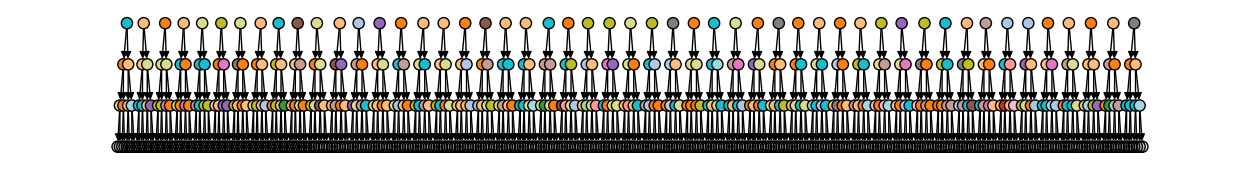

In [9]:
L1 = np.arange(len(xTrain.columns))
L2 = xTrain.columns
feature_names = {k:v for k,v in zip(L1,L2)}
feature_names[-2] = 'leaf'
ep = EnsemblePlot([],[],[],[])
ntrees = 50
G_all, graphs = ep.prune_ensemble_graph(tree_list[:ntrees], np.ones(shape = (ntrees,10)),feature_names, method = 'layers')
node_colors,cmap, legend_array = ep.get_colors(G_all, plot_legend = False)
mapping = legend_array[0]


scalarMap = legend_array[1]
pos1 = ep.pos_grid_layout(G_all, 1)


fig = plt.figure(figsize = (16,2))
ax = plt.subplot(111)
nx.draw(G_all,pos1,node_color = node_colors, 
        cmap = cmap,node_size = 65 , edgecolors = 'black' ,  with_labels = False)
for label in mapping:
    plt.plot([0],[0],color=scalarMap.to_rgba(mapping[label]),label=label,linewidth = 10)

plt.show()

### Get total number of decision rules

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    A, nodes = fire.get_rule_matrix_sparse(xTrain,rf.estimators_)
    A_test, _ = fire.get_rule_matrix_sparse(xTest,rf.estimators_)


A = A.toarray()
A_test = A_test.toarray()

s1 = preprocessing.StandardScaler()
A = s1.fit_transform(A)
A_test = s1.transform(A_test)

print('Number of Total Rules:', A.shape[1])

Number of Total Rules: 799


### Use FIRE to extract rules

In [11]:
gamma = 1.1
threshold = 10**-4
lambda1 = .1
w_MCP, ls = fire.MCP_CD(yTrain.values,A,lambda1,gamma,threshold)
fire_pred = A_test@w_MCP

print('Number of Extracted Rules:', sum(w_MCP != 0))
print('R-squared Extracted Rules ' , fire.r_squared(yTest,fire_pred,yTrain))

Number of Extracted Rules: 7
R-squared Extracted Rules  0.40223448239366055


### Visualize extracted rules

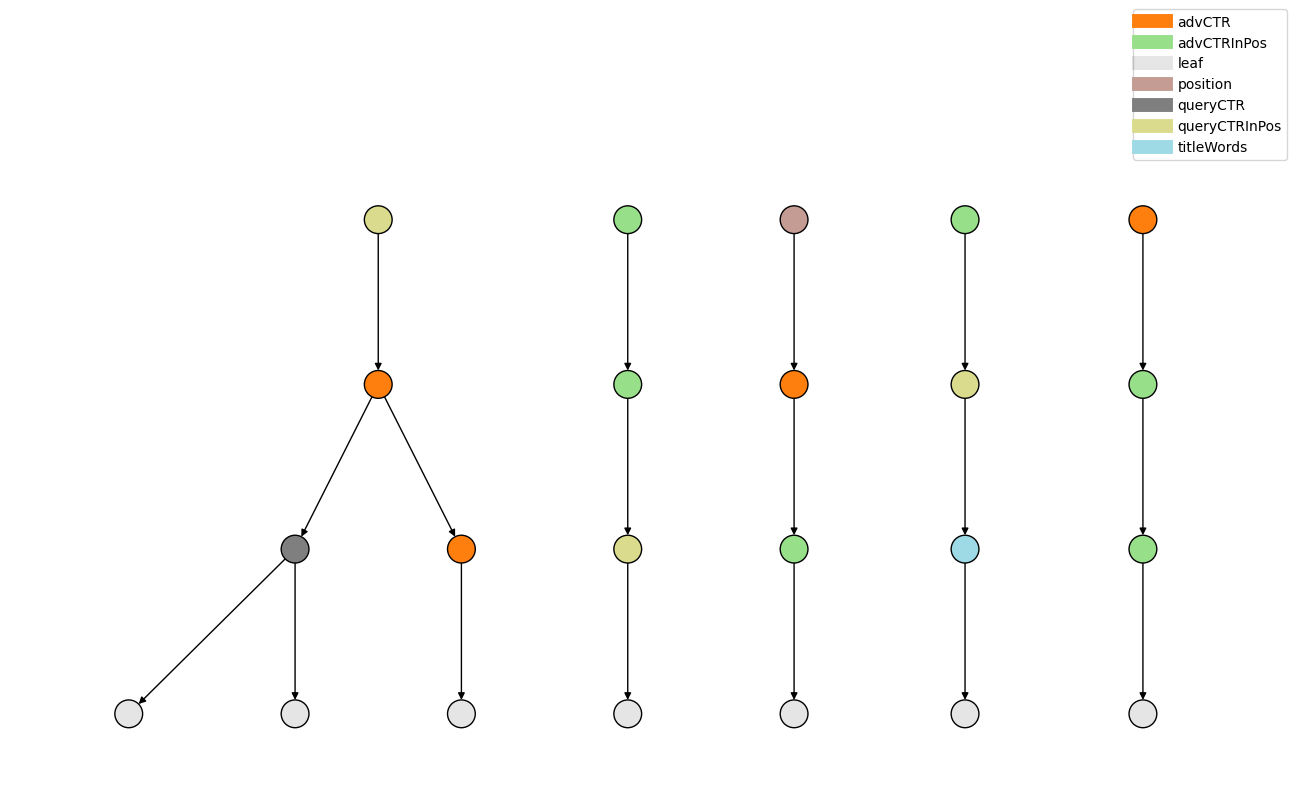

In [13]:
L1 = np.arange(len(xTrain.columns))
L2 = xTrain.columns
ep = EnsemblePlot([],[],[],[])
node_array_MCP = fire.analyze_nodes(nodes,w_MCP)
feature_names = {k:v for k,v in zip(L1,L2)}
feature_names[-2] = 'leaf'
tree_sub = []
node_array_sub= []
for i in range(len(node_array_MCP)):
    if sum(node_array_MCP[i])!=0:
        node_array_sub.append(node_array_MCP[i])
        tree_sub.append(rf.estimators_[i])
        
G_mcp, graphs_mcp = ep.prune_ensemble_graph(tree_sub,
                                           node_array_sub, 
                                   feature_names = feature_names, method = 'leaves')
node_colors,cmap, legend_array = ep.get_colors(G_mcp, plot_legend = False)
mapping = legend_array[0]


scalarMap = legend_array[1]
pos1 = ep.pos_grid_layout(G_mcp, 1)

fig = plt.figure(figsize = (16,8))
ax = plt.subplot(111)
nx.draw(G_mcp,pos1,node_color = node_colors, 
        cmap = cmap,node_size = 400 , edgecolors = 'black' ,  with_labels = False)
for label in mapping:
    plt.plot([0],[0],color=scalarMap.to_rgba(mapping[label]),label=label,linewidth = 10)
    

ax.legend(bbox_to_anchor=(.9, 1.))
plt.show()